Reference:https://github.com/suragnair/alpha-zero-general/tree/master/othello

## Required library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from keras.optimizers import Adam
import random
import os
import math
import copy
import tensorflow as tf
import numpy as np
import random
import copy
import pickle
import re
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import keras.optimizers
tf.keras.utils.disable_interactive_logging()

## Game environment

In [2]:

class Board:
    def __init__(self, player1, player2, n=6):
        self.n = n
        self.state_size = n * n
        self.action_size = n * n
        self.board = [[0] * n for _ in range(n)]
        self.current_play = 1
        self.reset()
        self.player1 = player1
        self.player2 = player2
        self.done = False
        self.directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

    def reset(self):
        n = self.n
        self.board = [[0] * n for _ in range(n)]
        self.current_play = 1
        if n % 2 == 0:
            mid = n // 2
            self.board[mid - 1][mid - 1] = 1
            self.board[mid][mid] = 1
            self.board[mid - 1][mid] = -1
            self.board[mid][mid- 1] = -1

    def get_board_state(self):
        return self.board

    def count_diff(self, color):
        count = 0
        for j in range(self.n):
            for i in range(self.n):
                if self.board[i][j] == color:
                    count += 1
                if self.board[i][j] == -color:
                    count -= 1
        return count

    def get_legal_moves(self, color):
        moves = set()
        for j in range(self.n):
            for i in range(self.n):
                if self.board[i][j] == color:
                    new_moves = self.get_moves_for_square((i, j))
                    moves.update(new_moves)
        return list(moves)

    def has_legal_moves(self, color):
        for j in range(self.n):
            for i in range(self.n):
                if self.board[i][j] == color:
                    new_moves = self.get_moves_for_square((i, j))
                    if len(new_moves) > 0:
                        return True
        return False

    def get_moves_for_square(self, square):
        (i, j) = square
        color = self.board[i][j]
        if color == 0:
            return None
        moves = []
        for direction in self.directions:
            move = self._discover_move(square, direction)
            if move:
                moves.append(move)
        return moves

    def execute_move(self, move, color):
        flips = []
        for direction in self.directions:
            flip = self._get_flips(move, direction, color)
            flips.extend(flip)

        if flips:
            for i, j in flips:
                self.board[i][j] = color
        else:
            raise Exception("Invalid move")
        row, col = move
        self.board[row][col] = color
        self.current_play = 1 if self.current_play == 1 else -1

    def _discover_move(self, origin, direction):
        i, j = origin
        color = self.board[i][j]
        flips = []
        for new_i, new_j in self._increment_move(origin, direction, self.n):
            if self.board[new_i][new_j] == 0:
                if flips:
                    return (new_i, new_j)
                else:
                    return None
            elif self.board[new_i][new_j] == color:
                return None
            elif self.board[new_i][new_j] == -color:
                flips.append((new_i, new_j))
        return None

    def _get_flips(self, origin, direction, color):
        flips = []
        for i, j in self._increment_move(origin, direction, self.n):
            if self.board[i][j] == 0:
                return []
            if self.board[i][j] == -color:
                flips.append((i, j))
            elif self.board[i][j] == color and len(flips) > 0:
                return flips
        return []

    def _increment_move(self, move, direction, n):
        move = tuple(move)[:2]  # Convert to tuple if it's a list
        i, j = move
        move = (i + direction[0], j + direction[1])
        while 0 <= move[0] < n and 0 <= move[1] < n:
            yield move
            move = (move[0] + direction[0], move[1] + direction[1])

    def get_reward(self):
        player1_score = self.count_diff(1)
        player2_score = self.count_diff(-1)
        if player1_score > player2_score:
            return 1
        elif player1_score < player2_score:
            return -1
        else:
            return 0

    def game_over(self):
        return not self.has_legal_moves(1) and not self.has_legal_moves(-1)

    ## Two player play against each other
    def play(self, rounds=200,inner_rounds=10):
        results = []
        for i in range(rounds):
            self.reset()
            current_player = self.player1 if self.current_play == 1 else self.player2
            if i % 100 == 0:
                print("Rounds {}".format(i))
            if i % 10 == 0:
                self.player1.setEps(rounds, i)
                self.player2.setEps(rounds, i)
            while True:
#                 self.print_board()
                positions = self.has_legal_moves(current_player.color)
                if positions:
                    p_move = current_player.choose_action(self)
                    self.execute_move(p_move, current_player.color)
                    current_player.addState(self.get_board_state())
                    state_after = copy.deepcopy(self.get_board_state())
                    current_player.addState(state_after)
                    if self.game_over():
                        winner = self.get_reward()
                        self.player1.feedReward(winner)
                        self.player2.feedReward(-winner)
                        results.append(winner)
                        self.player1.reset()
                        self.player2.reset()
                        self.reset()
                        break
                    current_player = self.player2 if current_player == self.player1 else self.player1
                else:
                    current_player = self.player2 if current_player == self.player1 else self.player1
                    if not (self.has_legal_moves(self.player1.color) or self.has_legal_moves(self.player2.color)):
                        self.player1.feedReward(0)
                        self.player2.feedReward(0)
                        results.append(0)
                        self.reset
                        break
            if i % inner_rounds==0:
                self.player1.sVNNtrain()
                self.player2.sVNNtrain()
            self.reset()

        return results

    def play2(self):
        self.reset()
        current_player = self.player1 if self.current_play == 1 else self.player2
        while True:
            positions = self.has_legal_moves(current_player.color)
            if positions:
                p_move = current_player.choose_action(self)
                self.execute_move(p_move, current_player.color)
                if self.game_over():
                    winner = self.get_reward()
                    if winner == 1:
                        return 1
                    elif winner == -1:
                        return -1
                    else:
                        return 0
                    break
                current_player = self.player2 if current_player == self.player1 else self.player1
            else:
                current_player = self.player2 if current_player == self.player1 else self.player1
                if not (self.has_legal_moves(self.player1.color) or self.has_legal_moves(self.player2.color)):
                    break
        return 0

    def NNPlay(self, rounds=200, inner_rounds=10,name_exp= None):


        print("training...")
        w1=self.play(rounds)

        self.player1.state_value_model.save(f"model2_p1_{name_exp}.keras")
        self.player2.state_value_model.save(f"model2_p2_{name_exp}.keras")

        analysis = []
        train_batches = int(rounds/inner_rounds) + 1
        for i in range(train_batches):
            start = inner_rounds * i
            end = inner_rounds * (i + 1)
            temp_p = w1[start:end]
            p1_wins = temp_p.count(1)
            p2_wins = temp_p.count(-1)
            ties = temp_p.count(0)
            analysis.append([i, start, end, p1_wins, p2_wins, ties])

        andf= pd.DataFrame(analysis)
        andf.columns = ['batch', 'start', 'end', 'p1win', 'p2win', 'tie']
        andf['p1win'] = andf['p1win'].apply(lambda x: x/inner_rounds)
        andf['p2win'] = andf['p2win'].apply(lambda x: x/inner_rounds)
        andf['tie'] = andf['tie'].apply(lambda x: x/inner_rounds)

        # Plot
        plt.plot(andf['batch'], andf['p1win'])
        plt.plot(andf['batch'], andf['p2win'])
        plt.plot(andf['batch'], andf['tie'])
        plt.legend(['p1 win', 'p2 win', 'tie'])
        #plt.title(title_string)
        plt.show()
        return

    def print_board(self):
        for i in range(self.n):
            print('.........................')
            print('|', end=' ')
            for j in range(self.n):
                if self.board[i][j] == 1:
                    print('B', end=' ')
                elif self.board[i][j] == -1:
                    print('W', end=' ')
                else:
                    print(' ', end=' ')
                print('|', end=' ')
            print()
        print('...........................')



## DQN agent class

In [3]:

class DQNAgent:

    def __init__(self, color, n=6, eps_decay=False, start_exp_rate=0.2, end_exp_rate=0.02):
        self.n = n
        self.color = color
        self.states = []
        self.lr = 1.0
        self.exp_rate = start_exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}
        self.eps_decay = eps_decay
        self.decay_rate= 0.005
        self.start_exp_rate = start_exp_rate
        self.end_exp_rate = end_exp_rate
        self.state_value_model = self.neural_network()

    def neural_network(self):
        model = keras.models.Sequential()
        model.add(Dense(units=36, input_dim=self.n * self.n, activation='relu'))
        model.add(Dense(18, activation='relu'))
        model.add(Dense(9, activation='relu'))
        model.add(Dense(1, activation='linear'))
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

    def get_hash(self, board):
        state_old = board.get_board_state()
        return np.array(state_old).flatten()

    def sNvalue(self, board):
        state_val = self.get_hash(board)
        state_val = state_val.reshape((1, self.n * self.n))
        pred = self.state_value_model.predict(state_val)[0]
        return pred

    def savemodel(self,path):
        self.state_value_model.save(path)

    def loadSVNNmodel(self, path):

        self.state_value_model = keras.models.load_model(path)
        
    ## Exponential epsilon decay
    def exponential_decay_value(self, current_step):
        epsilon = self.end_exp_rate + (self.start_exp_rate - self.end_exp_rate) * np.exp(-self.decay_rate * current_step)
        return epsilon

    def setEps(self, total_games, current_step):
        if self.eps_decay==False:
            return
        else:
            self.exp_rate = self.exponential_decay_value(current_step)
            if current_step % 10 == 0:
                print('Exploration rate modified at game {} with current value of {}'.format(current_step, self.exp_rate))

    def choose_action(self, board):
        legal_moves = board.get_legal_moves(self.color)
        if np.random.uniform(0,1) < self.exp_rate:
            action_index = np.random.choice(len(legal_moves))
            selected_action = legal_moves[action_index]
            return selected_action
        else:
            value_max = -999
            best_action = None
            for p in legal_moves:
                next_board = copy.deepcopy(board)
                next_board.execute_move(p, self.color)
                next_state_hash = self.get_hash(next_board)
                pred = self.sNvalue(next_board)
                if pred >= value_max:
                    value_max = pred
                    best_action = p
            return best_action

    def getbuffer(self):
        data = self.states_value
        ll = []
        for k in data.keys():
            k_str = str(k)
            yy = re.findall(r'[-/+]?\d+\.*\d*', k_str)
            zz = data.get(k)
            yy.append(zz)
            ll.append(yy)
        lldf = pd.DataFrame(ll)
        cols = ['x'+str(i) for i in range(self.n*self.n)]
        cols.append('val')
        lldf.columns = cols
        lldf.to_csv('Buffer1.csv', index=False)
        return

    def sVNNtrain(self, Xin=None, Yin=None,name_exp=None):
        self.getbuffer()
        df = pd.read_csv('Buffer1.csv')
#         print ('length of buffer is', len(df))
        traincols=['x' + str(i) for i in range(self.n*self.n)]
        testcol = 'val'
        if Xin is None:
            Xin = df[traincols]

            Yin = df[testcol]
        self.state_value_model.fit(Xin, Yin, epochs=10, verbose=False)
        self.state_value_model.save(f"model2_p1_{name_exp}.keras")
        self.states_value = {}
        return
    def addState(self, state):
        state_tuple = tuple(map(tuple, state))
        self.states.append(state_tuple)

    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]



    def reset(self):
        self.states = []


In [4]:
##

## Random player

In [5]:
class RandomPlayer:
    def __init__(self, color, name):
        self.color = color
        self.name = name

    def choose_action(self, board):
        legal_moves = board.get_legal_moves(self.color)
        if legal_moves:
            return random.choice(legal_moves)
        return None

    def addState(self, state, action, reward, next_state, done):
        pass

    def feedReward(self, minibatch):
        pass

    def reset(self):
        pass


In [6]:
# Test Method 1: 

def testgame(player1, player2, ngames):
    p1_wins = 0
    p2_wins = 0
    ties = 0

    for i in range(1, ngames + 1):
        board = Board(player1, player2, n=6)
        win = board.play2()
        if win == 1:
            p1_wins += 1
        elif win == -1:
            p2_wins += 1
        else:
            ties += 1

        # if i % 10 == 0:
        #     print(f"Games played: {i}")

    p1_win_probability = p1_wins / ngames
    p2_win_probability = p2_wins / ngames
    tie_probability = ties / ngames
    return p1_win_probability, p2_win_probability, tie_probability

In [7]:
player1 = DQNAgent(1,n=6,eps_decay=False, start_exp_rate=0.2, end_exp_rate=0.02)
player2 = DQNAgent(-1,n=6,eps_decay=False, start_exp_rate=0.2, end_exp_rate=0.02)

print(player1.exp_rate,player2.exp_rate)


0.2 0.2


## Training case 2 - Both player are decay

training...
Rounds 0
Exploration rate modified at game 0 with current value of 0.2
Exploration rate modified at game 0 with current value of 0.2



Exploration rate modified at game 10 with current value of 0.19122129641012853
Exploration rate modified at game 10 with current value of 0.19122129641012853
Exploration rate modified at game 20 with current value of 0.1828707352464727
Exploration rate modified at game 20 with current value of 0.1828707352464727
Exploration rate modified at game 30 with current value of 0.1749274357565104
Exploration rate modified at game 30 with current value of 0.1749274357565104
Exploration rate modified at game 40 with current value of 0.16737153555403675
Exploration rate modified at game 40 with current value of 0.16737153555403675
Exploration rate modified at game 50 with current value of 0.16018414095285288
Exploration rate modified at game 50 with current value of 0.16018414095285288
Exploration rate modified at game 60 with current value of 0.15334727972270923
Exploration rate modified at game 60 with current value of 0.15334727972270923
Exploration rate modified at game 70 with current value 

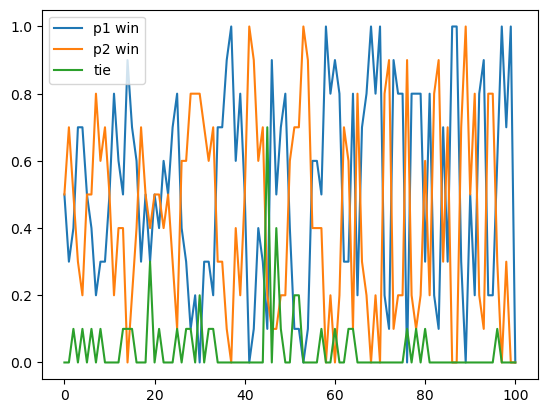

In [10]:
player1 = DQNAgent(1,n=6, eps_decay = True, start_exp_rate=0.2, end_exp_rate=0.02)
player2=DQNAgent(-1,n=6,eps_decay=True,start_exp_rate=0.2,end_exp_rate=0.02)
board=Board(player1,player2,n=6)
board.NNPlay(rounds=1000,name_exp="DP1_DP2")